## ANEXO 2: Análisis Exploratorio de Datos

In [1]:
import pandas as pd
import numpy as np
import geopandas
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

### Carga de datos

In [2]:
# se cargan los datos de la máquina local
df_full = pd.read_pickle(r"..\data\short.pkl")

In [3]:
# lista de columnas del dataframe
df_full = df_full[[
  "COMUNA", "DISTRITO", "ZONA",
  "N_VIVIENDA", "N_HOGAR", "N_PERSONA",
  "REGION", "ES_URBANO",
  "CENTROIDE_X_DIST", "CENTROIDE_Y_DIST",
  "POBLACION_DIST", "SUPERFICIE_DIST", "DENSIDAD_DIST",
  "EDAD", "PARENTESCO",
  "ES_ORIGINARIO", "PUEBLO_ORIGINARIO",
  "LUGAR_NAC", "LUGAR_NAC_PAIS",
  "ASISTE_EDUCACION", "ANOS_ESCOLARIDAD",
  "TRABAJO_REMUNERADO", "TOTAL_HIJOS",
  "HIJO_RECIENTE"
]]

In [4]:
# cantidad de filas y columnas del dataframe
df_full.shape

(4370993, 24)

### Análisis por edad

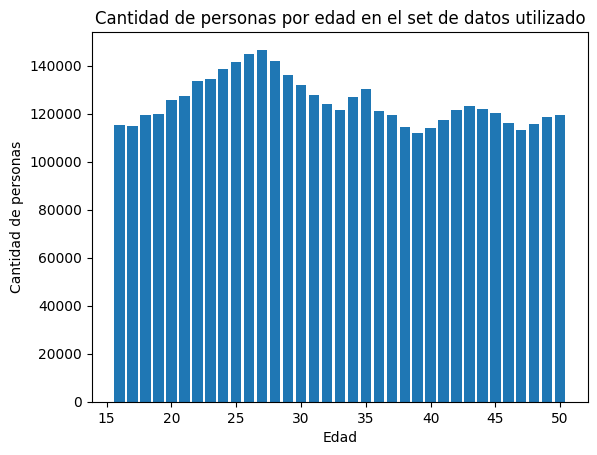

In [5]:
groups_edad = df_full.groupby("EDAD")["EDAD"].count().reset_index(name='counts')

plt.bar(groups_edad["EDAD"], groups_edad["counts"])
plt.xlabel("Edad")
plt.ylabel("Cantidad de personas")
plt.title("Cantidad de personas por edad en el set de datos utilizado")
plt.show()

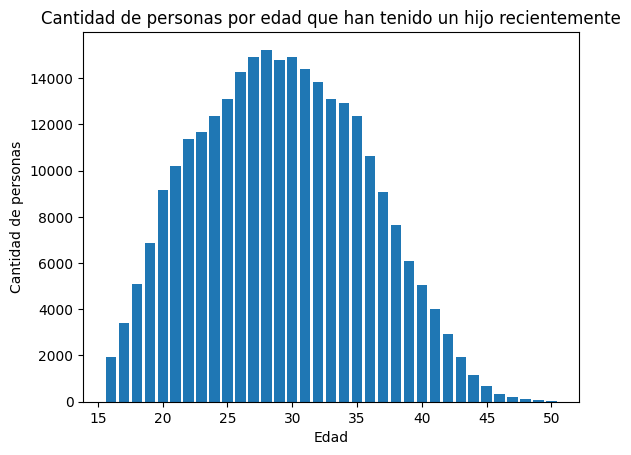

In [6]:
natalidad_por_edad = df_full.groupby("EDAD")["HIJO_RECIENTE"].sum().reset_index()

plt.bar(natalidad_por_edad["EDAD"], natalidad_por_edad["HIJO_RECIENTE"])
plt.xlabel("Edad")
plt.ylabel("Cantidad de personas")
plt.title("Cantidad de personas por edad que han tenido un hijo recientemente")
plt.show()

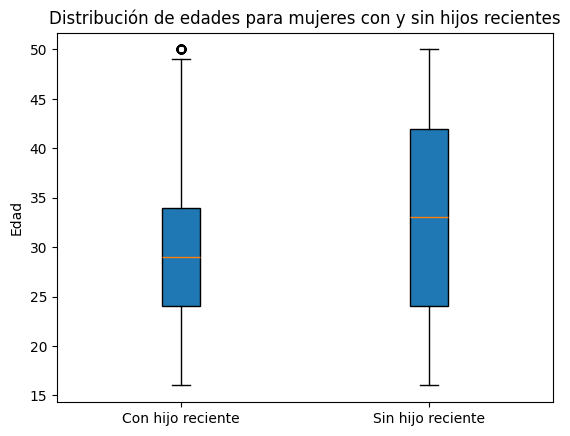

In [ ]:
edades_con_hijos = df_full[df_full["HIJO_RECIENTE"]==True]["EDAD"]
edades_sin_hijos = df_full[df_full["HIJO_RECIENTE"]==False]["EDAD"]

fig, ax = plt.subplots()
ax.boxplot([edades_con_hijos, edades_sin_hijos], patch_artist=True)
ax.set_xticklabels(["Con hijo reciente", "Sin hijo reciente"])
plt.ylabel("Edad")
plt.title("Distribución de edades para mujeres con y sin hijos recientes")

# Muestra the plot
plt.show()

### Análisis geográfico

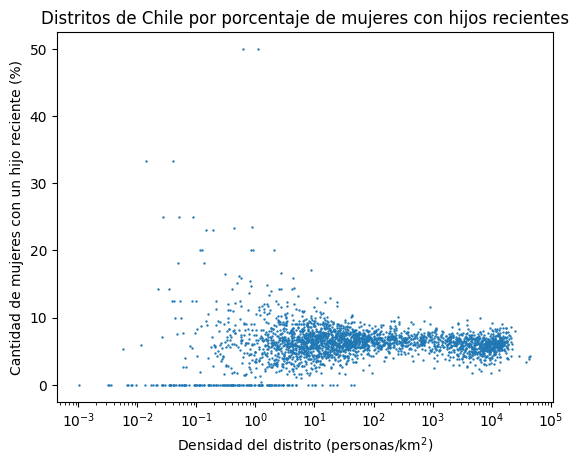

In [ ]:
natalidad_vs_densidad = df_full.groupby("DENSIDAD_DIST")["HIJO_RECIENTE"].mean().reset_index()

plt.scatter(natalidad_vs_densidad["DENSIDAD_DIST"], natalidad_vs_densidad["HIJO_RECIENTE"]*100, s=0.5)
plt.xscale("log")
plt.xlabel("Densidad del distrito (personas/km$^2$)")
plt.ylabel("Cantidad de mujeres con un hijo reciente (%)")
plt.title("Distritos de Chile por porcentaje de mujeres con hijos recientes")
plt.show()

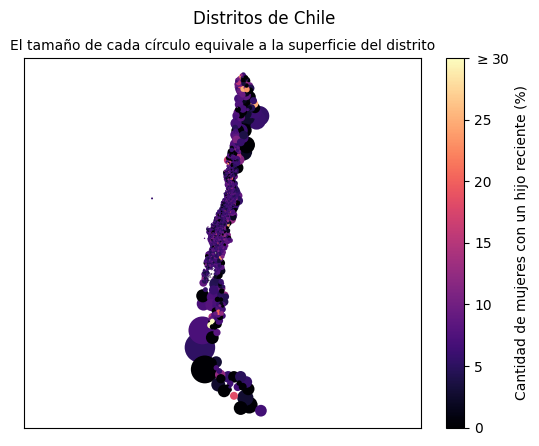

In [ ]:
natalidad_vs_area = df_full.groupby(["CENTROIDE_X_DIST", "CENTROIDE_Y_DIST", "SUPERFICIE_DIST", "COMUNA", "DISTRITO"])["HIJO_RECIENTE"].mean().reset_index().sort_values(by="SUPERFICIE_DIST", ascending=False)

fig, ax = plt.subplots()

sc = ax.scatter(natalidad_vs_area["CENTROIDE_X_DIST"], natalidad_vs_area["CENTROIDE_Y_DIST"], s=0.02*natalidad_vs_area["SUPERFICIE_DIST"], c=np.clip(natalidad_vs_area["HIJO_RECIENTE"]*100, 0, 30), linewidths=0, cmap="magma")
cbar = fig.colorbar(sc, ticks=[0, 5, 10, 15, 20, 25, 30])
cbar.ax.set_yticklabels([0, 5, 10, 15, 20, 25, "$\geq 30$"])
cbar.set_label("Cantidad de mujeres con un hijo reciente (%)")
ax.set_xlim(-10.5e6, -5.5e6)
ax.set_xticks([])
ax.set_yticks([])
fig.suptitle("Distritos de Chile")
ax.set_title("El tamaño de cada círculo equivale a la superficie del distrito", fontdict={"size":10})

plt.show()

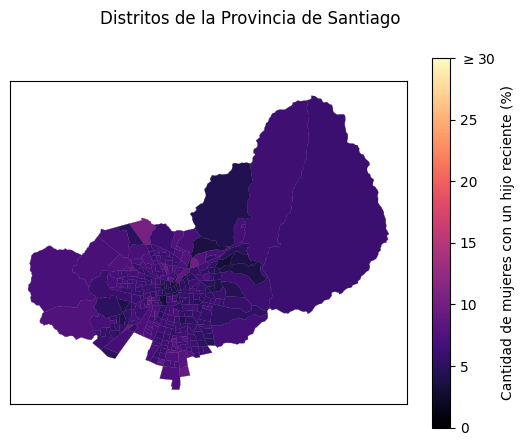

In [ ]:
gdf = geopandas.read_file(r"..\data\geografia_extra\Distrito_Densid_Superficie.shp")
gdf["COMUNA"] = gdf["COMUNA"].astype(int)

natalidad_vs_area_stgo = natalidad_vs_area[natalidad_vs_area["COMUNA"].astype(str).str.startswith("131")].copy()
natalidad_vs_area_stgo["HIJO_RECIENTE"] = natalidad_vs_area_stgo["HIJO_RECIENTE"] * 100
natalidad_vs_area_stgo = gdf.merge(
    natalidad_vs_area_stgo, how="inner",
    left_on=["COMUNA", "COD_DISTRI"],
    right_on=["COMUNA", "DISTRITO"],
    suffixes=("", "_g")
)

fig_stgo, ax_stgo = plt.subplots()

ax_stgo = natalidad_vs_area_stgo.plot(column="HIJO_RECIENTE", ax=ax_stgo, cmap="magma", edgecolor="face", linewidth=0.2)
ax_stgo.collections[0].set_clim(0, 30)
cbar_stgo = fig.colorbar(ax_stgo.collections[0], ticks=[0, 5, 10, 15, 20, 25, 30])
cbar_stgo.ax.set_yticklabels([0, 5, 10, 15, 20, 25, "$\geq 30$"])
cbar_stgo.set_label("Cantidad de mujeres con un hijo reciente (%)")
ax_stgo.set_xticks([])
ax_stgo.set_yticks([])
fig_stgo.suptitle("Distritos de la Provincia de Santiago")

plt.show()

### Análisis en varios atributos

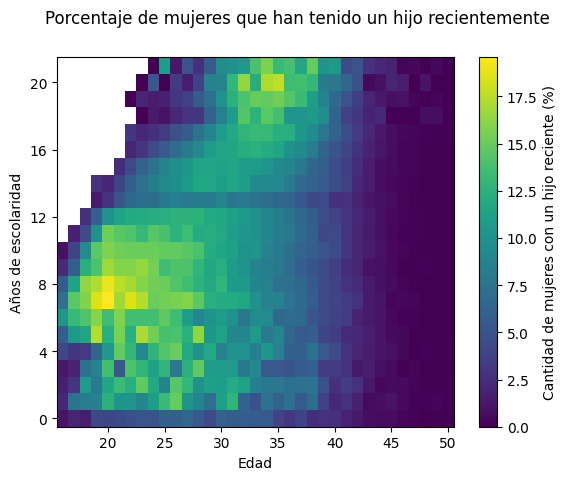

In [ ]:
df_edad_escolaridad = df_full.groupby(["ANOS_ESCOLARIDAD", "EDAD"])["HIJO_RECIENTE"].mean().unstack()

fig, ax = plt.subplots()
im = ax.imshow(df_edad_escolaridad*100, aspect="auto", origin="lower", extent=(15.5, 50.5, -0.5, 21.5))

cbar = fig.colorbar(im)
cbar.set_label("Cantidad de mujeres con un hijo reciente (%)")
ax.set_xlabel("Edad")
ax.set_ylabel("Años de escolaridad")
ax.yaxis.set_major_locator(mticker.MultipleLocator(4))
fig.suptitle("Porcentaje de mujeres que han tenido un hijo recientemente")
plt.show()

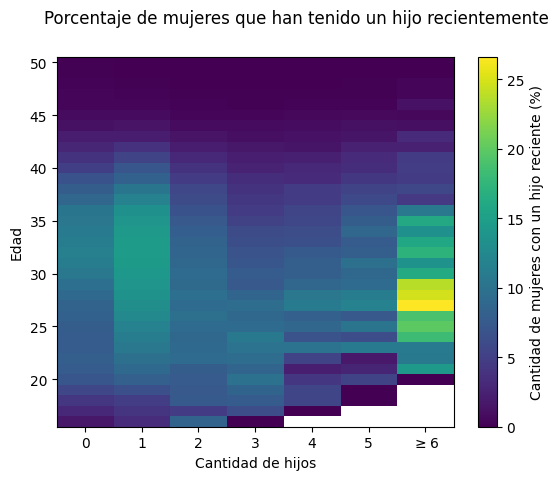

In [ ]:
df_edad_hijos = df_full.groupby(["TOTAL_HIJOS", "EDAD"])["HIJO_RECIENTE"].mean().reset_index()
df_edad_hijos.loc[df_edad_hijos["TOTAL_HIJOS"]>5, "TOTAL_HIJOS"] = 6
df_edad_hijos = df_edad_hijos.pivot_table(index="EDAD", columns="TOTAL_HIJOS", values="HIJO_RECIENTE")

fig, ax = plt.subplots()
im = ax.imshow(df_edad_hijos*100, aspect="auto", origin="lower", extent=(-0.5, 6.5, 15.5, 50.5))

cbar = fig.colorbar(im)
cbar.set_label("Cantidad de mujeres con un hijo reciente (%)")
ax.set_xticks(range(7), labels=[0, 1, 2, 3, 4, 5, "$\geq 6$"])
ax.set_xlabel("Cantidad de hijos")
ax.set_ylabel("Edad")
fig.suptitle("Porcentaje de mujeres que han tenido un hijo recientemente")
plt.show()


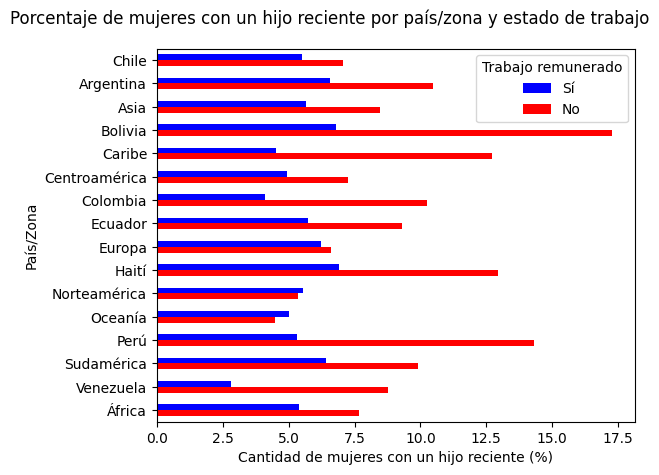

In [ ]:
df_pais_trabajo = df_full.groupby(['LUGAR_NAC_PAIS', 'TRABAJO_REMUNERADO'])['HIJO_RECIENTE'].mean().unstack()

df_chilenos = df_full[(df_full["LUGAR_NAC"]=="En otra comuna") | (df_full["LUGAR_NAC"]=="En esta comuna")]
df_chilenos = df_chilenos.groupby('TRABAJO_REMUNERADO')['HIJO_RECIENTE'].mean().to_frame().transpose()
df_chilenos = df_chilenos.rename(index={'HIJO_RECIENTE': 'Chile'})

df_pais_trabajo = pd.concat([df_chilenos, df_pais_trabajo])

df_pais_trabajo *= 100
df_pais_trabajo = df_pais_trabajo[[1, 0]]

fig, ax = plt.subplots()

df_pais_trabajo.plot(kind='barh', ax=ax, color={0: "red", 1: "blue"})
ax.invert_yaxis()

# Añadir etiquetas y título
ax.set_ylabel('País/Zona')
ax.set_xlabel('Cantidad de mujeres con un hijo reciente (%)')
fig.suptitle('Porcentaje de mujeres con un hijo reciente por país/zona y estado de trabajo')
ax.legend(title='Trabajo remunerado', labels=['Sí', 'No'])

fig.tight_layout()
plt.show()